In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
import random
import os
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [11]:
t = datasets.MNIST(root='./MNIST_data', train=False, download=True)
mean = t.data.float().mean() / 255
std = t.data.float().std() / 255
(mean, std)

(tensor(0.1325), tensor(0.3105))

In [12]:
mnist_transform = transforms.Compose([
               transforms.ToTensor(),
               transforms.Normalize((mean), (std)),
               ])

In [13]:
# Зафиксируем seed для воспроизводимости

def seed_everything(seed):
    random.seed(seed) # фиксируем генератор случайных чисел
    os.environ['PYTHONHASHSEED'] = str(seed) # фиксируем заполнения хешей
    np.random.seed(seed) # фиксируем генератор случайных чисел numpy
    torch.manual_seed(seed) # фиксируем генератор случайных чисел pytorch
    torch.cuda.manual_seed(seed) # фиксируем генератор случайных чисел для GPU
    torch.backends.cudnn.deterministic = True # выбираем только детерминированные алгоритмы (для сверток)
    torch.backends.cudnn.benchmark = False # фиксируем алгоритм вычисления сверток

In [14]:
seed_everything(42)

In [15]:
# on Mac Arm architecture use 'cpu' it's faster than use 'mps'

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [16]:
# set train, test and valid datasets
def mnist(batch_size=128, valid=0, shuffle=True, transform=mnist_transform, path='./MNIST_data'):
    test_data = datasets.MNIST(path, train=False, download=True, transform=transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    train_data = datasets.MNIST(path, train=True, download=True, transform=transform)
    if valid > 0:
        num_train = len(train_data)
        indices = list(range(num_train))
        split = num_train-valid
        np.random.shuffle(indices)

        train_idx, valid_idx = indices[:split], indices[split:]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
        valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
    
        return train_loader, valid_loader, test_loader
    else:
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
        return train_loader, test_loader

In [17]:
def plot_graphs(log, tpe='loss'):
    keys = log.keys()
    logs = {k:[z for z in zip(*log[k])] for k in keys}
    epochs = {k:range(len(log[k])) for k in keys}
    
    if tpe == 'loss':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][0], label=k) for k in keys])
        plt.title('errors')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend(handles=handlers)
        plt.show()
    elif tpe == 'accuracy':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][1], label=k) for k in log.keys()])
        plt.title('accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(handles=handlers)
        plt.show()

In [18]:
train_loader, valid_loader, test_loader = mnist(batch_size=256, valid=10000)

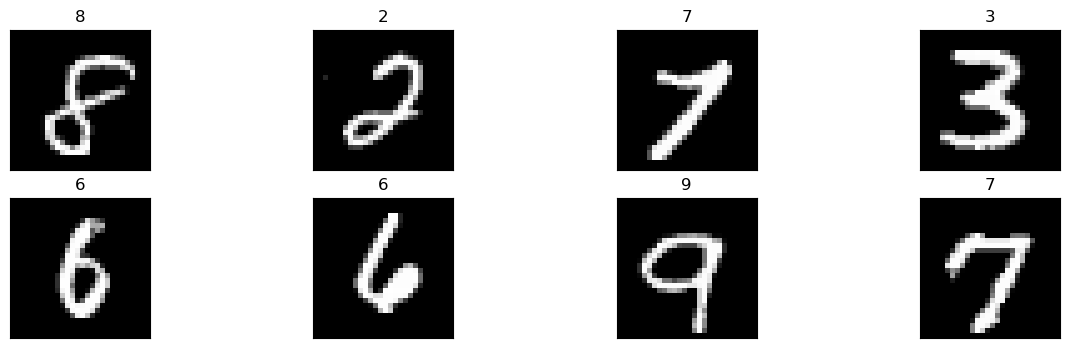

In [19]:
# Отрисуем 1 батч

dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

fig = plt.figure(figsize=(15, 4))
for idx in np.arange(8):
    ax = fig.add_subplot(2, 4, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

In [20]:
class Net(nn.Module):
    def __init__(self, optim_type='Adam', **optim_params):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 10)

        if optim_type == 'SGD':
            self.optim = optim.SGD(self.parameters(), **optim_params)
        elif optim_type == 'Adadelta':
            self.optim = optim.Adadelta(self.parameters(), **optim_params)
        elif optim_type == 'Adagrad':
            self.optim = optim.Adagrad(self.parameters(), **optim_params)
        elif optim_type == 'RMSProp':
            self.optim = optim.RMSprop(self.parameters(), **optim_params)
        elif optim_type == 'Adam':
            self.optim = optim.Adam(self.parameters(), **optim_params)
        elif optim_type == 'AdamW':
            self.optim = optim.AdamW(self.parameters(), **optim_params)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = self.fc4(x)
        x = F.log_softmax(x, dim=1)
        return x

    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        self._correct = output.data.max(1, keepdim=True)[1]
        self._correct = self._correct.eq(
            target.data.view_as(self._correct)).to(torch.float).cpu().mean()
        return self._loss

In [21]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
        else:
            batch_idx += 1
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            if log is not None:
                for k in models:
                    log[k].append((models[k]._loss, models[k]._correct))
        print(line + losses)

In [22]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], target, reduction='sum').item() # sum up batch loss
                pred = output[k].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: c.to(torch.float) / test_size for k, c in correct.items()}
    lines = '\n'.join([line(k, test_loss[k], correct[k], 100*correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [23]:
models = {
        'SGD': Net('SGD', lr=1e-3),
        'SGD with momentum': Net('SGD', lr=1e-3, momentum=0.9),
        'Adadelta': Net('Adadelta', lr=1),
        'RMSProp 5-2': Net('RMSProp', lr=5e-2),
        'RMSProp 1-2': Net('RMSProp', lr=1e-2),
        'RMSProp 1-3': Net('RMSProp', lr=1e-3),
        'Adam': Net('Adam', lr=3e-4), 
        'AdamW': Net('AdamW', lr=3e-4, weight_decay=0.001)
        }

train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [24]:
for epoch in range(1, 20):
    for model in models.values():
        model.to(device)
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses SGD: 2.300439 SGD with momentum: 2.306616 Adadelta: 2.329266 RMSProp 5-2: 2.294106 RMSProp 1-2: 2.306547 RMSProp 1-3: 2.306762 Adam: 2.321295 AdamW: 2.310582
Train Epoch: 1 [0/50000 (0%)]	Losses SGD: 2.300439 SGD with momentum: 2.306616 Adadelta: 2.329266 RMSProp 5-2: 2.294106 RMSProp 1-2: 2.306547 RMSProp 1-3: 2.306762 Adam: 2.321295 AdamW: 2.310582
Train Epoch: 1 [512/50000 (1%)]	Losses SGD: 2.299989 SGD with momentum: 2.292579 Adadelta: 2.132675 RMSProp 5-2: 8.813912 RMSProp 1-2: 3.505125 RMSProp 1-3: 2.171053 Adam: 2.279050 AdamW: 2.279764
Train Epoch: 1 [768/50000 (2%)]	Losses SGD: 2.293310 SGD with momentum: 2.291298 Adadelta: 1.929818 RMSProp 5-2: 21.722858 RMSProp 1-2: 7.338496 RMSProp 1-3: 1.675419 Adam: 2.255439 AdamW: 2.245838
Train Epoch: 1 [1024/50000 (2%)]	Losses SGD: 2.292239 SGD with momentum: 2.294818 Adadelta: 1.670275 RMSProp 5-2: 20.809420 RMSProp 1-2: 4.804763 RMSProp 1-3: 1.381858 Adam: 2.214413 AdamW: 2.202428
Train Epoch: 1 [

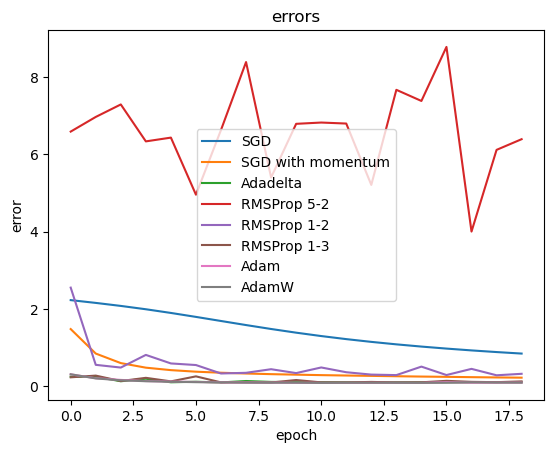

In [25]:
plot_graphs(test_log, 'loss')

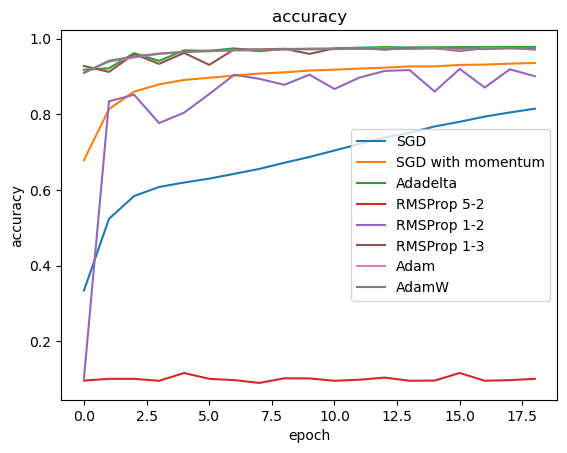

In [26]:
plot_graphs(test_log, 'accuracy')

<div class="alert alert-warning">В данном случае алгоритм 'RMSProp 5-2' пример неудачно выбранного гиперпараметра. Не смотря на лучшую реализацию оптимизатора он дает результ хуже чем ванильный SGD.</div>